In [1]:
import rasterio

# Check out a sample file
file_path = "light_map_2020.tif"

with rasterio.open(file_path) as src:
    print("File Name:", file_path)
    print("Projection information:", src.crs)  #Projection information (make sure it is WGS84, i.e. EPSG:4326)
    print("geographical scope:", src.bounds)  # Geographic range (latitude and longitude range)
    print("resolution:", src.res)  # Raster resolution
    print("Number of bands:", src.count)  # Check the number of bands

File Name: light_map_2020.tif
Projection information: EPSG:4326
geographical scope: BoundingBox(left=-79.80416666666693, bottom=40.558333333333465, right=-71.80000000000028, top=45.03333333333345)
resolution: (0.004166666666666655, 0.004166666666666655)
Number of bands: 1


In [3]:
import rasterio
import pandas as pd

file_path = "light_map_2020.tif" # This is the file we nee to process

# Open the file and extract the data
with rasterio.open(file_path) as src:
    data = src.read(1)  # Read the first band data
    rows, cols = data.shape  # Get the number of raster rows and columns
    results = []  # Used to store the brightness value and latitude and longitude of each pixel

    # Traverse each pixel
    for row in range(rows):
        for col in range(cols):
            value = data[row, col]  # Get pixel brightness value
            if value > 0:  # Filter out invalid or zero values
                lon, lat = src.xy(row, col)  # Get the latitude and longitude of the pixel
                results.append({"Latitude": lat, "Longitude": lon, "Brightness": value})

# Turn to Dataframe
df = pd.DataFrame(results)

# Save as csv file
df.to_csv("light_pollution_2020.csv", index=False)

print("The light pollution data extraction in 2020 is completed and has been saved as light_pollution_2020.csv")


The light pollution data extraction in 2020 is completed and has been saved as light_pollution_2020.csv


In [4]:
import pandas as pd

# Read the file we saved before
df = pd.read_csv("light_pollution_2020.csv")

# View statistics for brightness values
print(df["Brightness"].describe())

count    197346.000000
mean          6.850164
std          15.271329
min           0.500000
25%           0.600000
50%           1.300000
75%           5.300000
max         475.200000
Name: Brightness, dtype: float64


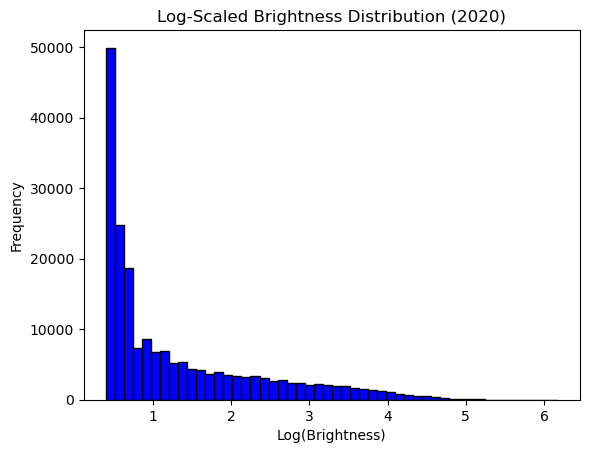

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 对亮度值进行对数变换
df["Log_Brightness"] = np.log1p(df["Brightness"])  # 使用 log(1 + Brightness) 避免 log(0)

# 绘制对数变换后的直方图
plt.hist(df["Log_Brightness"], bins=50, color="blue", edgecolor="black")
plt.title("Log-Scaled Brightness Distribution (2020)")
plt.xlabel("Log(Brightness)")
plt.ylabel("Frequency")

plt.savefig("log_scaled_brightness_distribution_2020.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
import pandas as pd

# 创建经纬度的网格
df["Lat_bin"] = pd.cut(df["Latitude"], bins=100)  # 将纬度分为100个区间
df["Lon_bin"] = pd.cut(df["Longitude"], bins=100)  # 将经度分为100个区间

# 计算每个网格的平均亮度
grid_data = df.groupby(["Lat_bin", "Lon_bin"])["Brightness"].mean().reset_index()

# 还原网格中心点
grid_data["Lat_center"] = grid_data["Lat_bin"].apply(lambda x: x.mid)  # 取纬度区间的中间值
grid_data["Lon_center"] = grid_data["Lon_bin"].apply(lambda x: x.mid)  # 取经度区间的中间值

# 检查生成的 `grid_data`
print(grid_data.head())

            Lat_bin             Lon_bin  Brightness Lat_center Lon_center
0  (40.568, 40.617]  (-79.802, -79.715]         NaN    40.5925   -79.7585
1  (40.568, 40.617]  (-79.715, -79.636]         NaN    40.5925   -79.6755
2  (40.568, 40.617]  (-79.636, -79.557]         NaN    40.5925   -79.5965
3  (40.568, 40.617]  (-79.557, -79.478]         NaN    40.5925   -79.5175
4  (40.568, 40.617]    (-79.478, -79.4]         NaN    40.5925   -79.4390


C:\Users\29468\AppData\Local\Temp\ipykernel_61928\3139333544.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grid_data = df.groupby(["Lat_bin", "Lon_bin"])["Brightness"].mean().reset_index()


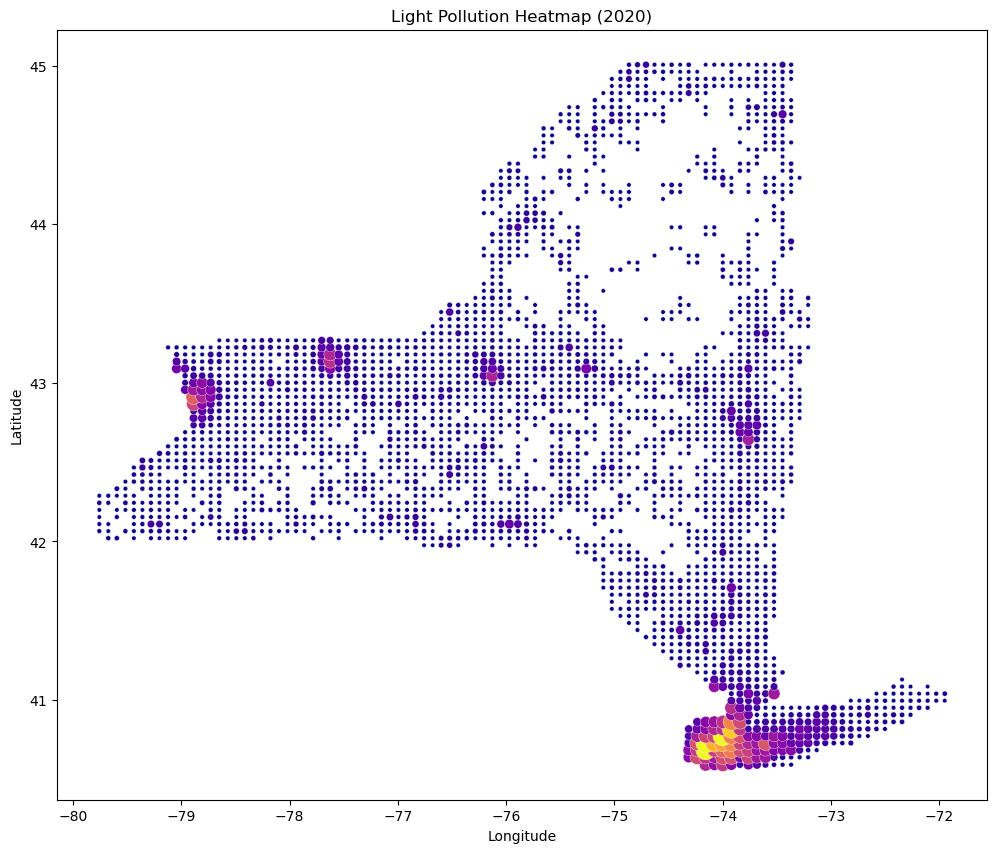

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制热力图
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x="Lon_center",  # 经度在 X 轴
    y="Lat_center",  # 纬度在 Y 轴
    size="Brightness", hue="Brightness",
    sizes=(10, 200), palette="plasma", data=grid_data, legend=None
)

# 翻转 Y 轴
plt.gca().invert_yaxis()

plt.title("Light Pollution Heatmap (2020)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# 保存图像为 PNG 文件
plt.savefig("light_pollution_heatmap_2020.png", dpi=300, bbox_inches='tight')  # 保存图像为 PNG
plt.show()